# Import Data

Create a pandas Dataframe by reading `data.json`

In [1]:
import pandas as pd

df = pd.read_json('data.json')

df['Average BMI'] = df[['Minimum BMI', 'Max BMI']].mean(axis=1)
df['Average BP'] = df[['Diastolic BP', 'Systolic BP']].mean(axis=1)

df.drop(columns=['Minimum BMI', 'Max BMI', 'Diastolic BP', 'Systolic BP'])

,MRN Deidentified,Age,Gender,Race,SPO2,Glaucoma,Medication Name,Total Med Count,IOP,Alcohol Use,Tobacco Use,Family History of Glaucoma with Vision Loss,Average BMI,Average BP
0,1000180,54.0,FEMALE,WHITE,99.000000,0,None,NaN,20.000000,Yes,Never,0,20.910,85.375000
1,1002053,69.0,MALE,WHITE,96.000000,0,None,NaN,15.000000,No,Never,0,22.460,91.500000
2,1002406,71.0,FEMALE,None,98.500000,1,"[CHLORTHALIDONE 25 MG TABLET, LISINOPRIL 40 MG...",2.0,158.500000,No,Never,0,35.660,95.321429
3,1004527,53.0,FEMALE,WHITE,98.375000,0,None,NaN,15.000000,No,Never,1,28.375,101.750000
4,1005441,81.0,MALE,WHITE,95.333333,1,None,NaN,NaN,No,Never,1,23.455,83.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,996238,65.0,FEMALE,WHITE,97.500000,0,None,NaN,NaN,No,Never,0,30.360,96.000000
3915,997539,100.0,MALE,WHITE,97.000000,1,None,NaN,NaN,Yes,Never,0,24.515,80.000000
3916,998282,78.0,FEMALE,WHITE,97.500000,1,None,NaN,300.183333,Yes,Quit,1,25.015,104.227273
3917,998343,80.0,FEMALE,WHITE,99.500000,1,None,NaN,16.617647,No,Never,0,23.770,98.125000


# Data Preprocessing
First we catagorize the columns based on the type of information they contain so they can later be encoded. Columns that contain numerical information, like age or IOP, are put into `numerical_cols`, while columns that contain information that can be found in a set of catagories, like *Gender*, which can be either `'MALE'` or `'FEMALE'`, is put in `categorical_cols`

## Removing `NaN` and Missing Values
For each of the numerical columns, we replace missing values with `-1`, and for the categorical columns we replace missing values with `'NONE'`

## Scaling and Encoding Values
The ColumnTransformer is set up with three transformers:
- `'num'` applies `StandardScaler` to the numerical columns, which is used to standardize (`mean=0`, `standard deviation=1`) numerical features.
- `'cat'` applies `OneHotEncoder` to the categorical columns, which converts categorical variables into a form that could be provided to ML algorithms (dummy variables).
- `'passthrough'` simply passes the specified columns through without any changes.

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numerical_cols = ['Age', 'Average BMI', 'SPO2', 'Average BP', 'Total Med Count']
categorical_cols = ['Race', 'Tobacco Use', 'Alcohol Use']
binary_categorical_cols = ['Gender']
passthrough_cols = ['Glaucoma']

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', numerical_imputer),
                                ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', categorical_imputer),
                                ('encoder', OneHotEncoder())]), categorical_cols),
        ('lab', OrdinalEncoder(), binary_categorical_cols),
        ('passthrough', 'passthrough', passthrough_cols)
    ])

# Display an example of the preprocessed data by creating a DataFrame, then displaying it
transformed_data = preprocessor.fit_transform(df)
new_column_names = numerical_cols + \
                   list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)) + \
                   binary_categorical_cols + \
                   passthrough_cols

transformed_df = pd.DataFrame(transformed_data, columns=new_column_names)

NameError: name 'df' is not defined

# Slit Data Into Training and Testing Sets
First, split the glaucoma column apart from the data, then split the data into 80% training data and 20% testing data.

In [3]:
from sklearn.model_selection import train_test_split

X = transformed_df.drop('Glaucoma', axis=1)
y = transformed_df['Glaucoma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create Models
Create each base model that will become a part of the stack and use hyperparameter-tuning to optimize each model.

## Random Forest

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

'''
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

print('RF params:', rf_grid_search.best_params_)
'''

best_rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=200, 
    max_features='sqrt', 
    min_samples_split=10, 
    max_depth=10, 
    min_samples_leaf=2, 
    bootstrap=True)

## Gradient Boosting

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

'''
gb_param_grid = {
    'n_estimators': [200],  # Number of boosting stages to be run
    'learning_rate': [0.03],  # Shrinks the contribution of each tree by learning_rate
    'max_depth': [4],  # Maximum depth of the individual regression estimators
    'min_samples_split': [6],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node
    'max_features': [None],  # The number of features to consider when looking for the best split
    'subsample': [0.5, 1.0]  # The fraction of samples to be used for fitting the individual base learners
}

gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=5, n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

print('GB params:', gb_grid_search.best_params_)
'''

best_gb_model = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=200, 
    learning_rate=0.03, 
    max_depth=4, 
    min_samples_split=6, 
    min_samples_leaf=2, 
    max_features=None, 
    subsample=1.0)

## C Support Vector

In [6]:
from sklearn.svm import SVC

'''
svc_param_grid = {
    'C': [0.1, 1],  # Regularization parameter
    'gamma': [1, 0.1],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Specifies the kernel type to be used in the algorithm
    'degree': [2, 3],  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
    'class_weight': [None, 'balanced'],  # Set the parameter C of class i to class_weight[i]*C for SVC. 
}


svc_grid_search = GridSearchCV(SVC(), svc_param_grid, cv=3, n_jobs=-1, verbose=2)
svc_grid_search.fit(X_train, y_train)
best_svc_model = svc_grid_search.best_estimator_

print('SVC params:', svc_grid_search.best_params_)
'''

best_svc_model = SVC(
    C=1, 
    class_weight=None, 
    degree=2, 
    gamma=0.1, 
    kernel='poly')

## Custom Neural Network
The data is best predicted by a neural network because the patterns in the data are well-captured by the architectures and feature hierarchies that deep learning models, like those built with Keras, can learn. Deep learning models, particularly those with multiple layers, are very effective at automatically detecting complex patterns and interactions between features without the need for manual feature engineering.

### Defining and Compiling the Model

In [7]:


def create_neural_network(input_dim):
    model = models.Sequential([
        tf.keras.Input(shape=(input_dim,)),  # Input layer specifying the shape
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

### Wrapping the Model in `KerasClassifier`
Also implement early stopping to prevent over-fitting

In [8]:
import tensorflow as tf

from sklearn.base import BaseEstimator, ClassifierMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=100, batch_size=10, validation_split=0.2):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split

    def fit(self, X, y, **kwargs):
        self.model = self._build_model()
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                       validation_split=self.validation_split, callbacks=[early_stopping], verbose=0, **kwargs)
        return self

    def _build_model(self):
        model = models.Sequential([
            tf.keras.Input(shape=(self.input_dim,)),  # Input layer specifying the shape
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def predict(self, X, **kwargs):
        predictions = self.model.predict(X, **kwargs)
        return (predictions > 0.5).astype(int)

    def score(self, X, y, **kwargs):
        loss, accuracy = self.model.evaluate(X, y, **kwargs)
        return accuracy

best_nn_model = KerasClassifierWrapper(input_dim=X_train.shape[1])

# Define and Tune Stacking

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

base_models = [
    ('random_forest', best_rf_model),
    ('gradient_boosting', best_gb_model),
    ('svc', best_svc_model),
    ('neural_net', best_nn_model)
]

meta_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear'],  # Algorithm to use in the optimization problem
    'penalty': ['l2'],  # Regularization penalty (depending on the solver, you might explore 'l1' as well)
}

meta_model_grid_search = GridSearchCV(LogisticRegression(max_iter=10000), meta_param_grid, cv=5, n_jobs=-1, verbose=3)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=10000), cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 20.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 26.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 30.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(learning_rate=0.03,
                                                           max_depth=4,
                                                           min_samples_leaf=2,
                                                           min_samples_split=6,
                                                           n_estimators=200,
                                                           random_state=42)),
                               ('svc',
                                SVC(C=1, degree=2, gamma=0.1, kernel='poly')),
                               ('neural_net',
                                KerasClassifierWrapper(input_dim=30))],
                   final_estimator=LogisticRegression(max_iter=10000))

# Determine Accuracy
Accuracy is determined by letting the model predict the target of the data previously reserved for testing, and then comparing it to the actual values for that data.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import check_is_fitted

# Accuracy of individual models
for name, model in base_models:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'{name} Model Accuracy: {accuracy}')

y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Stacking Model Accuracy: {accuracy}')

random_forest Model Accuracy: 0.6211734693877551
gradient_boosting Model Accuracy: 0.6211734693877551
svc Model Accuracy: 0.6275510204081632
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
neural_net Model Accuracy: 0.6186224489795918
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Stacking Model Accuracy: 0.6441326530612245


# Plot Importance of Features

random_forest True


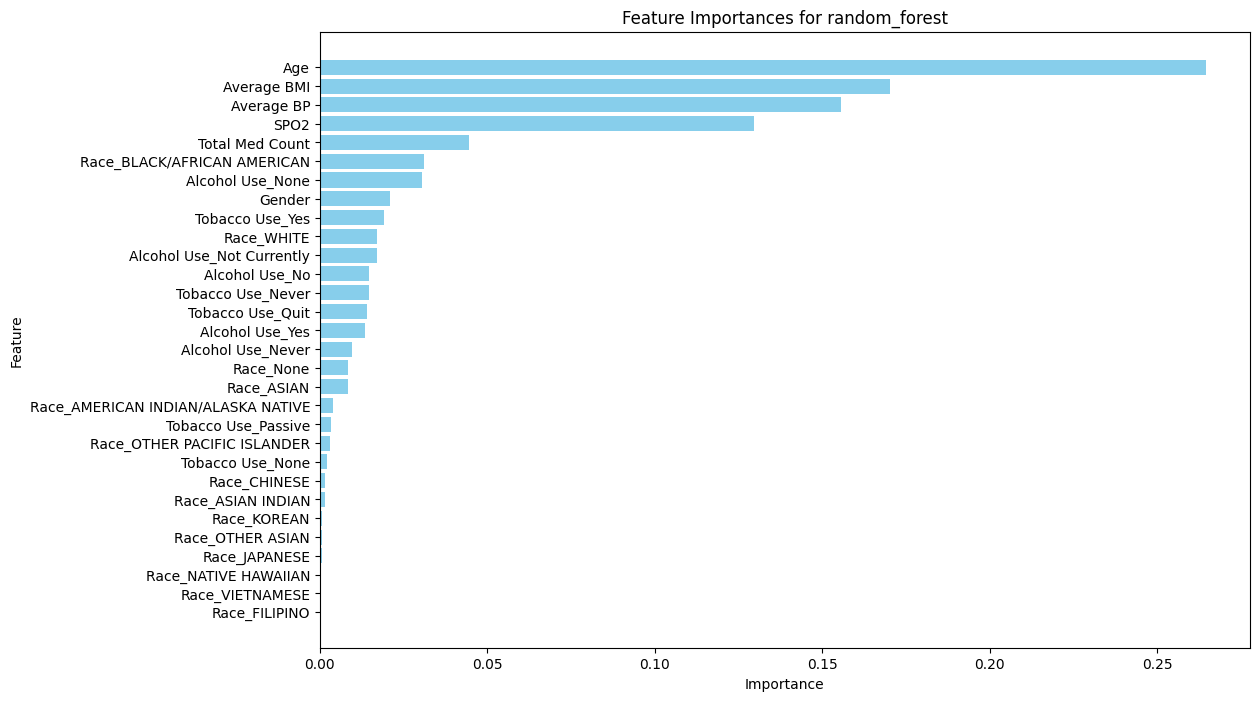

gradient_boosting True


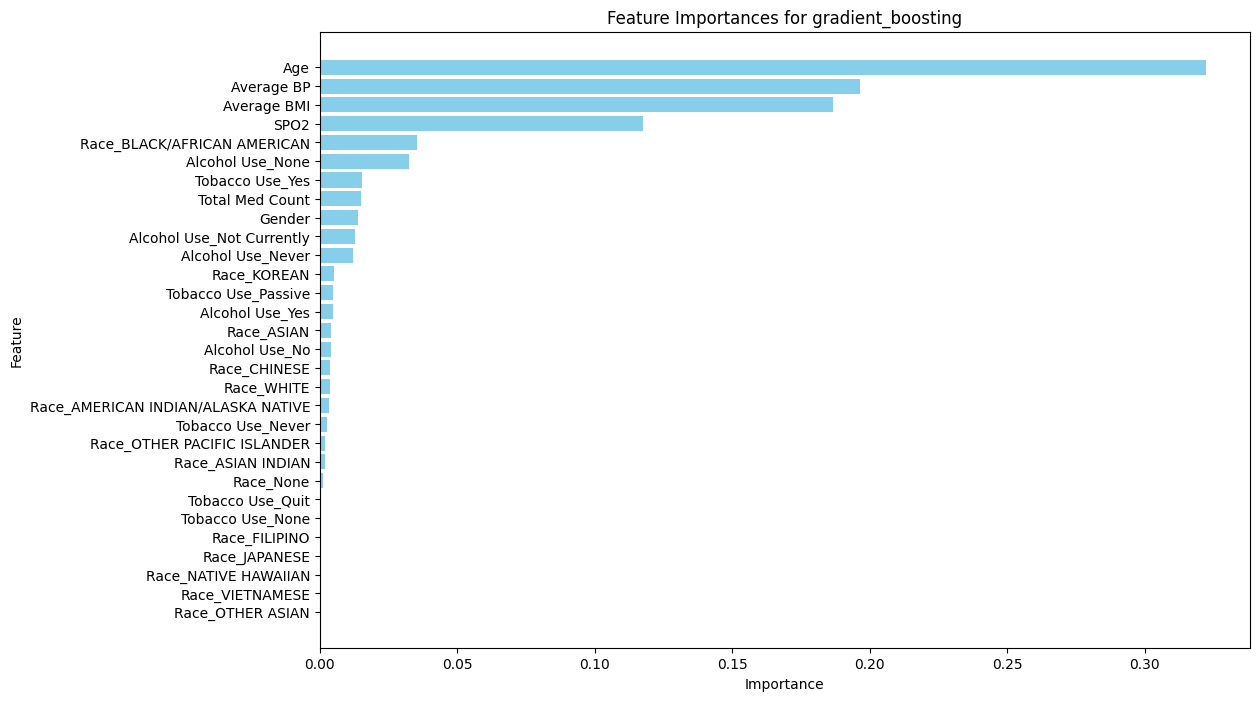

svc False
neural_net False


In [11]:
import matplotlib.pyplot as plt
import numpy as np

for name, model in stacking_model.estimators:
    print(f'{name} {hasattr(model, 'feature_importances_')}')
    if hasattr(model, 'feature_importances_'):
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances for {name}")
        importances = model.feature_importances_
        indices = np.argsort(importances)
        plt.barh(range(len(importances)), importances[indices], color='skyblue')
        plt.yticks(range(len(importances)), np.array(X_train.columns)[indices])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()